*School of Computer Sciences, USM • CDS522: Text and Speech Analytics • Semester 1, 2020/2021*

# CDS522 Group Project

## Title: A Text Analytics Approach to Study Python Questions Posted on Stack Overflow

Lee Yong Meng (P-COM0012/20) • Soo Yin Yi (P-COM0123/19)

Date: 6 January 2021

## Overview

- [**Section 1: Libraries and Data Processing**](#sec1)
- [**Section 2: Text Processing Stage 1**](#sec2)
- [**Section 3: Experiment 1 - Topic Modelling on Questions from Different Years**](#sec3)
  - [3-1: Text Processing Stage 2](#3_1)
  - [3-2: LDA Models](#3_2)
  - [3-3: Visualization and Evaluation](#3_3)
- [**Section 4: Experiment 2 - Topic Modelling on Questions with High Scores**](#sec4)
  - [4-1: Text Processing Stage 2](#4_1)
  - [4-2: LDA Models](#4_2)
  - [4-3: Visualization and Evaluation](#4_3)
  - [4-4: Hyperparameter Tuning](#4_4)

# Section 1: Libraries and Data Processing <a name="sec1"></a>

### Import libraries

Run the following cell to import all libraries used in this project (you might need to install many of these libraries).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime                             # extract question creation year
import re                                   # regex library to remove punctuation
from bs4 import BeautifulSoup               # convert HTML script to text
import spacy                                # lemmatization
from pprint import pprint                   # More sophisticated (pretty) print function
from wordcloud import WordCloud             # Generate word cloud
import pickle                               # save model
import tqdm                                 # progress bar

# Gensim module
import gensim
from gensim.utils import simple_preprocess  # word tokenization
import gensim.corpora as corpora            # corpora/corpus
from gensim.models import LdaMulticore      # LDA model
from gensim.models import CoherenceModel    # coherence: evaluation metric for LDA model

# NLTK module
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords # stopword

# Viz tool for LDA Model
import pyLDAvis.gensim
import pyLDAvis
pyLDAvis.enable_notebook()

%matplotlib inline

### Dataset Preparation

Load the question dataset (i.e., Python questions on Stack Overflow, available on [Kaggle](https://www.kaggle.com/stackoverflow/pythonquestions)) that is stored in the file named "Questions.csv" in the folder "dataset". Then, inspect the dataset.

The following are the attributes of the dataset:
- `Id`: categorical - Question ID, the identity attribute
- `OwnerUserId`: categorical - User ID, indicating the Stack Overflow user who posts the question.
- `CreationDate`: date - the complete date in which the question is posted.
- `Score`: quantitative - accumulated score (number of upvotes and downvotes) received by the question.
- `Title`: text - the title of the question.
- `Body`: text - the description of the question.

The attribute `Body` is selected as the main source of text for our analysis. 

In [2]:
file = "dataset/Questions.csv"

df = pd.read_csv(file, engine='python') # specify engine, for Jupyter Notebook
df

Id  OwnerUserId          CreationDate  Score  \
0            469        147.0  2008-08-02T15:11:16Z     21   
1            502        147.0  2008-08-02T17:01:58Z     27   
2            535        154.0  2008-08-02T18:43:54Z     40   
3            594        116.0  2008-08-03T01:15:08Z     25   
4            683        199.0  2008-08-03T13:19:16Z     28   
...          ...          ...                   ...    ...   
607277  40143190     333403.0  2016-10-19T23:36:01Z      1   
607278  40143228    6662462.0  2016-10-19T23:40:00Z      0   
607279  40143267    4064680.0  2016-10-19T23:44:07Z      0   
607280  40143338    7044980.0  2016-10-19T23:52:27Z      2   
607281  40143365    4133131.0  2016-10-19T23:55:49Z      0   

                                                    Title  \
0       How can I find the full path to a font from it...   
1                 Get a preview JPEG of a PDF on Windows?   
2       Continuous Integration System for a Python Cod...   
3          cx_Oracle: How do I iterate over a result set?   
4       Using 'in' to match an attribute of Python obj...   
...                                                   ...   
607277  How to execute multiline python code from a ba...   
607278  How to get google reCaptcha image source using...   
607279      Updating an ManyToMany field with Django rest   
607280                                Most possible pairs   
607281            Theano operations returning odd results   

                                                     Body  
0       <p>I am using the Photoshop's javascript API t...  
1       <p>I have a cross-platform (Python) applicatio...  
2       <p>I'm starting work on a hobby project with a...  
3       <p>There are several ways to iterate over a re...  
4       <p>I don't remember whether I was dreaming or ...  
...                                                   ...  
607277  <p>I need to extend a shell script (bash). As ...  
607278  <p>I understood that reCaptcha loads a new fra...  
607279  <p>I'm trying to set up this API so I can use ...  
607280  <p>Given a list of values, and information on ...  
607281  <p>So I'm trying to learn how to use Theano an...  

[607282 rows x 6 columns]

The original dataset consists of 600K questions with 6 attributes. To narrow down the scope of our analysis, we remove all the questions with negative scores (i.e., the value for the attribute `Score` below 0).

In [3]:
# Remove rows with negative score
df_nonneg = df[df['Score'] >= 0]
df_nonneg = df_nonneg.reset_index()

In [4]:
df_nonneg = df_nonneg.drop(['index'], axis=1)
df_nonneg

Id  OwnerUserId          CreationDate  Score  \
0            469        147.0  2008-08-02T15:11:16Z     21   
1            502        147.0  2008-08-02T17:01:58Z     27   
2            535        154.0  2008-08-02T18:43:54Z     40   
3            594        116.0  2008-08-03T01:15:08Z     25   
4            683        199.0  2008-08-03T13:19:16Z     28   
...          ...          ...                   ...    ...   
570967  40143190     333403.0  2016-10-19T23:36:01Z      1   
570968  40143228    6662462.0  2016-10-19T23:40:00Z      0   
570969  40143267    4064680.0  2016-10-19T23:44:07Z      0   
570970  40143338    7044980.0  2016-10-19T23:52:27Z      2   
570971  40143365    4133131.0  2016-10-19T23:55:49Z      0   

                                                    Title  \
0       How can I find the full path to a font from it...   
1                 Get a preview JPEG of a PDF on Windows?   
2       Continuous Integration System for a Python Cod...   
3          cx_Oracle: How do I iterate over a result set?   
4       Using 'in' to match an attribute of Python obj...   
...                                                   ...   
570967  How to execute multiline python code from a ba...   
570968  How to get google reCaptcha image source using...   
570969      Updating an ManyToMany field with Django rest   
570970                                Most possible pairs   
570971            Theano operations returning odd results   

                                                     Body  
0       <p>I am using the Photoshop's javascript API t...  
1       <p>I have a cross-platform (Python) applicatio...  
2       <p>I'm starting work on a hobby project with a...  
3       <p>There are several ways to iterate over a re...  
4       <p>I don't remember whether I was dreaming or ...  
...                                                   ...  
570967  <p>I need to extend a shell script (bash). As ...  
570968  <p>I understood that reCaptcha loads a new fra...  
570969  <p>I'm trying to set up this API so I can use ...  
570970  <p>Given a list of values, and information on ...  
570971  <p>So I'm trying to learn how to use Theano an...  

[570972 rows x 6 columns]

Now that there are 570K questions left in the dataset. Next, we derive new attribute `CreationYear` by extracting year from the attribute `CreationDate` for each question.

In [5]:
dates = list(df_nonneg['CreationDate'])
date_format = '%Y-%m-%dT%H:%M:%SZ'

years = [datetime.datetime.strptime(date, date_format).year for date in dates]

df_nonneg['CreationYear'] = years
df_nonneg

Id  OwnerUserId          CreationDate  Score  \
0            469        147.0  2008-08-02T15:11:16Z     21   
1            502        147.0  2008-08-02T17:01:58Z     27   
2            535        154.0  2008-08-02T18:43:54Z     40   
3            594        116.0  2008-08-03T01:15:08Z     25   
4            683        199.0  2008-08-03T13:19:16Z     28   
...          ...          ...                   ...    ...   
570967  40143190     333403.0  2016-10-19T23:36:01Z      1   
570968  40143228    6662462.0  2016-10-19T23:40:00Z      0   
570969  40143267    4064680.0  2016-10-19T23:44:07Z      0   
570970  40143338    7044980.0  2016-10-19T23:52:27Z      2   
570971  40143365    4133131.0  2016-10-19T23:55:49Z      0   

                                                    Title  \
0       How can I find the full path to a font from it...   
1                 Get a preview JPEG of a PDF on Windows?   
2       Continuous Integration System for a Python Cod...   
3          cx_Oracle: How do I iterate over a result set?   
4       Using 'in' to match an attribute of Python obj...   
...                                                   ...   
570967  How to execute multiline python code from a ba...   
570968  How to get google reCaptcha image source using...   
570969      Updating an ManyToMany field with Django rest   
570970                                Most possible pairs   
570971            Theano operations returning odd results   

                                                     Body  CreationYear  
0       <p>I am using the Photoshop's javascript API t...          2008  
1       <p>I have a cross-platform (Python) applicatio...          2008  
2       <p>I'm starting work on a hobby project with a...          2008  
3       <p>There are several ways to iterate over a re...          2008  
4       <p>I don't remember whether I was dreaming or ...          2008  
...                                                   ...           ...  
570967  <p>I need to extend a shell script (bash). As ...          2016  
570968  <p>I understood that reCaptcha loads a new fra...          2016  
570969  <p>I'm trying to set up this API so I can use ...          2016  
570970  <p>Given a list of values, and information on ...          2016  
570971  <p>So I'm trying to learn how to use Theano an...          2016  

[570972 rows x 7 columns]

After that, we remove unused attributes from the dataset. As a result, there are only 3 attributes left: `Score`, `Body` and `CreationYear`.

In [6]:
cols_drop = ['Id', 'OwnerUserId', 'Title', 'CreationDate']

df_nonneg = df_nonneg.drop(cols_drop, axis=1)
df_nonneg

Score                                               Body  CreationYear
0          21  <p>I am using the Photoshop's javascript API t...          2008
1          27  <p>I have a cross-platform (Python) applicatio...          2008
2          40  <p>I'm starting work on a hobby project with a...          2008
3          25  <p>There are several ways to iterate over a re...          2008
4          28  <p>I don't remember whether I was dreaming or ...          2008
...       ...                                                ...           ...
570967      1  <p>I need to extend a shell script (bash). As ...          2016
570968      0  <p>I understood that reCaptcha loads a new fra...          2016
570969      0  <p>I'm trying to set up this API so I can use ...          2016
570970      2  <p>Given a list of values, and information on ...          2016
570971      0  <p>So I'm trying to learn how to use Theano an...          2016

[570972 rows x 3 columns]

We are ready for the first part of our text processing.

# Section 2: Text Preprocessing Stage 1<a name="sec2"></a>

### Remove Punctuation and Lowercasing

From the original questions, we first remove the punctuations by using the regular expression (Python's [`re`](https://docs.python.org/3/library/re.html) library). Then, we also convert all the characters in the text to lower case. The text after preprocessing is stored into the new attribute `BodyLower`.

In [7]:
# Remove punctuation
df_nonneg['BodyLower'] = df_nonneg['Body'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the question body to lowercase
df_nonneg['BodyLower'] = df_nonneg['BodyLower'].map(lambda x: x.lower())

# Print the first few records for the column: body_processed
body_lower = list(df_nonneg['BodyLower'])

for i in range(5):
    print(body_lower[i])
    print("---\n")

<>:2: DeprecationWarning: invalid escape sequence \.
<>:2: DeprecationWarning: invalid escape sequence \.
<ipython-input-7-427b622908cf>:2: DeprecationWarning: invalid escape sequence \.
  df_nonneg['BodyLower'] = df_nonneg['Body'].map(lambda x: re.sub('[,\.!?]', '', x))


<p>i am using the photoshop's javascript api to find the fonts in a given psd</p>

<p>given a font name returned by the api i want to find the actual physical font file that that font name corresponds to on the disc</p>

<p>this is all happening in a python program running on osx so i guess i'm looking for one of:</p>

<ul>
<li>some photoshop javascript</li>
<li>a python function</li>
<li>an osx api that i can call from python</li>
</ul>

---

<p>i have a cross-platform (python) application which needs to generate a jpeg preview of the first page of a pdf</p>

<p>on the mac i am spawning <a href="http://developerapplecom/documentation/darwin/reference/manpages/man1/sips1html">sips</a>  is there something similarly simple i can do on windows</p>

---

<p>i'm starting work on a hobby project with a python codebase and would like to set up some form of continuous integration (ie running a battery of test-cases each time a check-in is made and sending nag e-mails to responsible persons whe

As you can see from the samples of the question description, the text itself is written in HTML. Some of the question descriptions also contain code blocks (i.e., the syntax of Python or any other programming languages). Without addressing these issues, we might end up getting all the HTML tags as the frequent terms in our analysis. This will certainly affect the result of our analysis. The next question is:

> What is the possible next step?

### Remove Code Blocks and Transform Question Descriptions from HTML to Normal Text

We use Python's [`BeautifulSoup`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library from the `bs4` module to handle HTML. The question descriptions after processing are stored in the new attribute `BodyProcessed`.

In [8]:
# from bs4 import BeautifulSoup

# count = 0
body_lower = list(df_nonneg['BodyLower'])
body_processed = []

for i, body in enumerate(body_lower):
    # Create instance of BeautifulSoup to remove codeblock 
    # - <pre><code> ... </code></pre>
    soap = BeautifulSoup(body)
    
    for codeblock in soap("pre"):
        body = body.replace(str(codeblock), '')
    
    # Create new instance of BeautifulSoup to convert
    # HTML to string.
    new_soap = BeautifulSoup(body)
    new_body = new_soap.get_text()
    
    body_processed.append(new_body)

# print(count)
df_nonneg['BodyProcessed'] = body_processed
df_nonneg

Score                                               Body  \
0          21  <p>I am using the Photoshop's javascript API t...   
1          27  <p>I have a cross-platform (Python) applicatio...   
2          40  <p>I'm starting work on a hobby project with a...   
3          25  <p>There are several ways to iterate over a re...   
4          28  <p>I don't remember whether I was dreaming or ...   
...       ...                                                ...   
570967      1  <p>I need to extend a shell script (bash). As ...   
570968      0  <p>I understood that reCaptcha loads a new fra...   
570969      0  <p>I'm trying to set up this API so I can use ...   
570970      2  <p>Given a list of values, and information on ...   
570971      0  <p>So I'm trying to learn how to use Theano an...   

        CreationYear                                          BodyLower  \
0               2008  <p>i am using the photoshop's javascript api t...   
1               2008  <p>i have a cross-platform (python) applicatio...   
2               2008  <p>i'm starting work on a hobby project with a...   
3               2008  <p>there are several ways to iterate over a re...   
4               2008  <p>i don't remember whether i was dreaming or ...   
...              ...                                                ...   
570967          2016  <p>i need to extend a shell script (bash) as i...   
570968          2016  <p>i understood that recaptcha loads a new fra...   
570969          2016  <p>i'm trying to set up this api so i can use ...   
570970          2016  <p>given a list of values and information on p...   
570971          2016  <p>so i'm trying to learn how to use theano an...   

                                            BodyProcessed  
0       i am using the photoshop's javascript api to f...  
1       i have a cross-platform (python) application w...  
2       i'm starting work on a hobby project with a py...  
3       there are several ways to iterate over a resul...  
4       i don't remember whether i was dreaming or not...  
...                                                   ...  
570967  i need to extend a shell script (bash) as i am...  
570968  i understood that recaptcha loads a new frame ...  
570969  i'm trying to set up this api so i can use a "...  
570970  given a list of values and information on poss...  
570971  so i'm trying to learn how to use theano and s...  

[570972 rows x 5 columns]

We inspect the first 5 question descriptions after preprocessing. 

In [9]:
for i in range(5):
    print(body_processed[i])
    print("---")

i am using the photoshop's javascript api to find the fonts in a given psd
given a font name returned by the api i want to find the actual physical font file that that font name corresponds to on the disc
this is all happening in a python program running on osx so i guess i'm looking for one of:

some photoshop javascript
a python function
an osx api that i can call from python


---
i have a cross-platform (python) application which needs to generate a jpeg preview of the first page of a pdf
on the mac i am spawning sips  is there something similarly simple i can do on windows

---
i'm starting work on a hobby project with a python codebase and would like to set up some form of continuous integration (ie running a battery of test-cases each time a check-in is made and sending nag e-mails to responsible persons when the tests fail) similar to cruisecontrol or teamcity
i realize i could do this with hooks in most vcses but that requires that the tests run on the same machine as the vers

**\[Checkpoint\]** Save the processed data.

Before moving further, we save the processed dataset with 3 attributes (`Score`, `CreationYear`, and `BodyProcessed`) into a CSV file.

In [10]:
# Create new data frame
df_nonneg_save = df_nonneg[['Score', 'CreationYear', 'BodyProcessed']]
df_nonneg_save

Score  CreationYear                                      BodyProcessed
0          21          2008  i am using the photoshop's javascript api to f...
1          27          2008  i have a cross-platform (python) application w...
2          40          2008  i'm starting work on a hobby project with a py...
3          25          2008  there are several ways to iterate over a resul...
4          28          2008  i don't remember whether i was dreaming or not...
...       ...           ...                                                ...
570967      1          2016  i need to extend a shell script (bash) as i am...
570968      0          2016  i understood that recaptcha loads a new frame ...
570969      0          2016  i'm trying to set up this api so i can use a "...
570970      2          2016  given a list of values and information on poss...
570971      0          2016  so i'm trying to learn how to use theano and s...

[570972 rows x 3 columns]

In [11]:
%%time

# Save processed question data
df_nonneg_save.to_csv('output/Questions_processed.csv')

Wall time: 7.87 s


The following two sections demonstrate topic modelling on the Python questions posted on Stack Overflow under different settings, namely:
- **Experiment 1: Topic Modelling on Questions from Different Years**
  - The dataset is split according to each topic. Then, the question description are further preprocessed for each year, followed by LDA model building, its visualization and evaluation for different years.
- **Experiment 2: Topic Modelling on Questions with High Scores**
  - The dataset is filtered with a threshold value (only questions with high score are selected). Then, the processes in **Experiment 1** (text preprocessing, LDA model building, visualization and evaluation) are repeated, but the dataset is not further split by year. Finally, hyperparameter tuning (testing with different number of topics) is conducted, the parameter (number of topics) with the best model performance is rebuilt, the outputs include wordcloud and LDA visualization.

# Section 3: Experiment 1 - Topic Modelling on Questions from Different Years <a name="sec3"></a>

There are more text processing tasks before we can apply topic modelling on the questions. First, we split our questions by years.

In [12]:
%%time

dict_questions_by_year = dict()

years = list(df_nonneg['CreationYear'].unique())

for year in years:
    question_list = list(df_nonneg[df_nonneg['CreationYear'] == year]['BodyProcessed'])
    dict_questions_by_year[year] = question_list
    
    print(len(question_list))

1920
12301
26091
40198
59568
86880
103057
122156
118801
Wall time: 319 ms


As shown above, the number of Python questions posted on Stack Overflow is gradually increasing per year from 2008 - 2016 (without considering questions with negative scores).

## 3-1: Text Processing Stage 2 <a name="3_1"></a>

### Word tokenization

We define helper function: `sent_to_words()` to help us tokenize the question descriptions from sentence(s) to words.

In [13]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

Perform word tokenization on question descriptions for each year. Then, inspect (up to) the first 30 tokens from the first question for each year.

In [14]:
data_words_by_year = dict()

for year in years:
    data_words = list(sent_to_words(dict_questions_by_year[year]))
    data_words_by_year[year] = data_words
    print("Year {}\n{}\n---".format(year, data_words[:1][0][:30]))

Year 2008
['am', 'using', 'the', 'photoshop', 'javascript', 'api', 'to', 'find', 'the', 'fonts', 'in', 'given', 'psd', 'given', 'font', 'name', 'returned', 'by', 'the', 'api', 'want', 'to', 'find', 'the', 'actual', 'physical', 'font', 'file', 'that', 'that']
---
Year 2009
['does', 'anyone', 'know', 'how', 'to', 'write', 'program', 'in', 'python', 'that', 'will', 'calculate', 'the', 'addition', 'of', 'the', 'harmonic', 'series', 'ie']
---
Year 2010
['why', 'print', 'in', 'front', 'of', 'sysstderr', 'thanks']
---
Year 2011
['gae', 'supports', 'both', 'incoming', 'and', 'outgoing', 'emails', 'http', 'codegooglecom', 'appengine', 'docs', 'python', 'mail', 'have', 'any', 'open', 'source', 'email', 'clients', 'been', 'written', 'for', 'gae', 'something', 'that', 'handles', 'encoding', 'issues', 'attachments', 'grouping']
---
Year 2012
['ve', 'started', 'to', 'learn', 'python', 'with', 'lpthw', 'and', 've', 'gotten', 'to', 'exercise', 'http', 'book', 'ex', 'html', 'and', 'feel', 'like', 'an',

**\[checkpoint\]** Save the list of tokenized sentences `data_words_by_year`.

In [15]:
%%time

file_data_words = open("output/data_words_year.pkl", "wb")
pickle.dump(data_words_by_year, file_data_words)
file_data_words.close()

print("Success!")

Success!
Wall time: 1min 2s


Verify that the `data_words_by_year` is saved successfully.

In [16]:
%%time

file_data_words = open("output/data_words_year.pkl", "rb")
data_words_year = pickle.load(file_data_words)

for year in data_words_year.keys():
    print("Year {}\n{}\n---".format(year, data_words_year[year][:1][0][:30]))

print("Success!")

Year 2008
['am', 'using', 'the', 'photoshop', 'javascript', 'api', 'to', 'find', 'the', 'fonts', 'in', 'given', 'psd', 'given', 'font', 'name', 'returned', 'by', 'the', 'api', 'want', 'to', 'find', 'the', 'actual', 'physical', 'font', 'file', 'that', 'that']
---
Year 2009
['does', 'anyone', 'know', 'how', 'to', 'write', 'program', 'in', 'python', 'that', 'will', 'calculate', 'the', 'addition', 'of', 'the', 'harmonic', 'series', 'ie']
---
Year 2010
['why', 'print', 'in', 'front', 'of', 'sysstderr', 'thanks']
---
Year 2011
['gae', 'supports', 'both', 'incoming', 'and', 'outgoing', 'emails', 'http', 'codegooglecom', 'appengine', 'docs', 'python', 'mail', 'have', 'any', 'open', 'source', 'email', 'clients', 'been', 'written', 'for', 'gae', 'something', 'that', 'handles', 'encoding', 'issues', 'attachments', 'grouping']
---
Year 2012
['ve', 'started', 'to', 'learn', 'python', 'with', 'lpthw', 'and', 've', 'gotten', 'to', 'exercise', 'http', 'book', 'ex', 'html', 'and', 'feel', 'like', 'an',

### Building Bigram from Tokenized Sentences

The [`Gensim`](https://radimrehurek.com/gensim/auto_examples/index.html) library enables creation of bigram models from tokenized sentences.

In [17]:
%%time

# For computation by year
bigram_mod_year = dict()

for year in years:
    bigram = gensim.models.Phrases(data_words_by_year[year],
                                   min_count=5, 
                                   threshold=100) # higher threshold fewer phrases.
    
    bigram_mod_year[year] = gensim.models.phrases.Phraser(bigram)

Wall time: 2min 54s


**\[checkpoint\]** Save the bigram models.

In [18]:
%%time

with open('output/bigram_mod_year.pickle', 'wb') as bigram_mod:
    pickle.dump(bigram_mod_year, bigram_mod)
    
print("Success!")

Success!
Wall time: 43.4 ms


Verify that the bigram models are saved successfully.

In [19]:
%%time

with open('output/bigram_mod_year.pickle', 'rb') as bigram_mod:
    bigram_mod_year = pickle.load(bigram_mod)

print("Success!")

Success!
Wall time: 174 ms


### Remove Stopwords and Lemmatization

Finally, we remove the stopwords from the tokens. We remove the English stopwords as listed in the [`NLTK`](https://www.nltk.org/) (short for "Natural Language Toolkit") library.

In [20]:
stop_words = stopwords.words('english')

These are some helper functions for further text preprocessing.

In [21]:
# Define functions for stopwords, bigrams, and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts, bigram_mod):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

After removing stopwords, we also perform lemmatization on the tokens for each year.

In [23]:
%%time

data_lemmatized_year = dict()

for year in data_words_year.keys():
    # Remove stopwords
    data_words_nostop = remove_stopwords(data_words_year[year])
    
    # Form Bigrams
    data_words_bigram = make_bigrams(data_words_nostop, bigram_mod_year[year])
    
    # Initialize spacy 'en' model, keeping only tager component (for efficiency)
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    
    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized_year[year] = lemmatization(data_words_bigram, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print("Success!")
    
for year in data_words_year.keys():
    print("Year {}".format(year))
    print(data_lemmatized_year[year][:1][0][:30])
    print("---")

print("Success!")

Success!
Year 2008
['use', 'find', 'font', 'give', 'give', 'font', 'name', 'return', 'want', 'find', 'actual', 'physical', 'font', 'file', 'font', 'name', 'correspond', 'disc', 'happen', 'program', 'run', 'guess', 'look', 'function', 'call']
---
Year 2009
['know', 'write', 'program', 'addition']
---
Year 2010
['print', 'thank']
---
Year 2011
['support', 'incoming', 'outgoing', 'email', 'appengine', 'open', 'source', 'email', 'client', 'write', 'handle', 'encode', 'issue', 'attachment', 'group', 'conversation']
---
Year 2012
['start', 'learn', 'get', 'exercise', 'http', 'book', 'feel', 'idiot', 'figure', 'seemingly', 'simple', 'assignment', 'want', 'follow', 'condense', 'line', 'code', 'try', 'follow', 'rewrite', 'line', 'line', 'line', 'string', 'line', 'try', 'various', 'combination', 'quote', 'keep']
---
Year 2013
['characterize', 'point', 'value', 'indicate', 'point', 'position', 'height', 'intensity', 'point', 'issue', 'data', 'coordinate', 'axis', 'extremely', 'closely', 'space', 

**\[Checkpoint\]** Save the lemmatized tokens.

In [24]:
%%time

with open('output/data_lemmatized_year.pickle', 'wb') as data_lemmatized:
    pickle.dump(data_lemmatized_year, data_lemmatized)
    
print("Success!")

Success!
Wall time: 11.1 s


Verify that the lemmatized tokens are saved successfully.

In [25]:
%%time

with open('output/data_lemmatized_year.pickle', 'rb') as data_lemmatized:
    data_lemmatized_year = pickle.load(data_lemmatized)
        
print("Success!")

for year in data_lemmatized_year.keys():
    print("Year {}".format(year))
    print(data_lemmatized_year[year][:1][0][:30])
    print("---")

print("Success!")

Success!
Year 2008
['use', 'find', 'font', 'give', 'give', 'font', 'name', 'return', 'want', 'find', 'actual', 'physical', 'font', 'file', 'font', 'name', 'correspond', 'disc', 'happen', 'program', 'run', 'guess', 'look', 'function', 'call']
---
Year 2009
['know', 'write', 'program', 'addition']
---
Year 2010
['print', 'thank']
---
Year 2011
['support', 'incoming', 'outgoing', 'email', 'appengine', 'open', 'source', 'email', 'client', 'write', 'handle', 'encode', 'issue', 'attachment', 'group', 'conversation']
---
Year 2012
['start', 'learn', 'get', 'exercise', 'http', 'book', 'feel', 'idiot', 'figure', 'seemingly', 'simple', 'assignment', 'want', 'follow', 'condense', 'line', 'code', 'try', 'follow', 'rewrite', 'line', 'line', 'line', 'string', 'line', 'try', 'various', 'combination', 'quote', 'keep']
---
Year 2013
['characterize', 'point', 'value', 'indicate', 'point', 'position', 'height', 'intensity', 'point', 'issue', 'data', 'coordinate', 'axis', 'extremely', 'closely', 'space', 

## 3-2: LDA Models <a name="3_2"></a>

### Build LDA Model

We will create instances of [`ldaMultiCore`](https://radimrehurek.com/gensim/models/ldamulticore.html) from `Gensim` library as our LDA models for topic modelling. Therefore, we need to create the corpus and dictionary as the parameter values to intiialize the properties of our LDA models. 

In [27]:
%%time

id2word_year = dict()
corpus_year = dict()

for year in data_lemmatized_year.keys():
    texts = data_lemmatized_year[year]
    
    id2word_year[year] = corpora.Dictionary(texts)
    corpus_year[year] = [id2word_year[year].doc2bow(text) for text in texts]
    
    print("Year {}".format(year))
    print(corpus_year[year][:1][0][:30])
    print("---")

print("Success!")

Year 2008
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 4), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]
---
Year 2009
[(0, 1), (1, 1), (2, 1), (3, 1)]
---
Year 2010
[(0, 1), (1, 1)]
---
Year 2011
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)]
---
Year 2012
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 5), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2)]
---
Year 2013
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 4), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 4), (28, 1), (29, 1)]
---
Year 2014
[(0, 2), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1

Helper function to create the LDA Model.

In [28]:
def create_lda_model(corpus, id2word, num_topics=10):
    return LdaMulticore(
        corpus=corpus, id2word=id2word, num_topics=num_topics, 
        random_state=100, chunksize=100, passes=10, per_word_topics=True)

Then, create LDA model using the helper function for each year.

In [29]:
%%time

lda_model_year = dict()

for year in corpus_year.keys():
    lda_model_year[year] = create_lda_model(corpus=corpus_year[year],
                                            id2word=id2word_year[year],
                                            num_topics=5)

print("Success!")

Success!
Wall time: 42min 58s


### Inspect Keywords by Topic for each LDA Model

Inspect LDA model keywords by topic.

In [30]:
def show_word_cloud_by_topic(model, num_topic=None, num_words=200):
    # Generate word cloud for each topic
    k = num_topic if num_topic is not None else model.num_topics
    
    for t in range(k):
        # Configure dictionary
        str_word_frequency = model.show_topics(num_words=num_words)[t][1]
        list_word_frequency = str_word_frequency.split('+')
        dict_word_frequency = dict()

        for wf in list_word_frequency:
            wf_clean = wf.strip()
            dict_wf_key = wf_clean[6:].replace("\"", "")
            dict_wf_val = float(wf_clean[:5])
            dict_word_frequency[dict_wf_key] = dict_wf_val

        # Generate WordClooud
        plt.figure()
        plt.imshow(WordCloud(background_color="white", contour_width=4, contour_color='steelblue').fit_words(dict_word_frequency))
        plt.axis("off")
        plt.title("Topic #" + str(t))
        plt.show()

# Reference: https://stackoverflow.com/questions/40278023/how-do-i-print-lda-topic-model-and-the-word-cloud-of-each-of-the-topics

List the keywords using [`pprint()`](https://docs.python.org/3/library/pprint.html) function.

In [31]:
%%time

# Print keywords per topic for each model
for year in lda_model_year.keys():
    print("Year {}".format(year))
    pprint(lda_model_year[year].print_topics())
    print("---")
    
print("Success!")

Year 2008
[(0,
  '0.020*"use" + 0.019*"list" + 0.018*"way" + 0.017*"would" + 0.013*"function" '
  '+ 0.011*"want" + 0.011*"string" + 0.010*"value" + 0.009*"object" + '
  '0.009*"method"'),
 (1,
  '0.025*"use" + 0.010*"thread" + 0.009*"run" + 0.008*"file" + 0.008*"email" + '
  '0.008*"server" + 0.007*"application" + 0.007*"look" + 0.007*"connection" + '
  '0.007*"want"'),
 (2,
  '0.027*"use" + 0.016*"code" + 0.011*"file" + 0.010*"would" + 0.009*"write" + '
  '0.008*"import" + 0.008*"script" + 0.008*"need" + 0.007*"work" + '
  '0.007*"want"'),
 (3,
  '0.023*"use" + 0.013*"would" + 0.010*"way" + 0.010*"try" + 0.008*"work" + '
  '0.008*"make" + 0.007*"need" + 0.007*"function" + 0.007*"get" + 0.007*"run"'),
 (4,
  '0.024*"file" + 0.016*"use" + 0.012*"work" + 0.011*"want" + 0.010*"try" + '
  '0.010*"way" + 0.009*"run" + 0.008*"get" + 0.008*"user" + 0.007*"set"')]
---
Year 2009
[(0,
  '0.023*"function" + 0.021*"class" + 0.020*"use" + 0.015*"would" + '
  '0.014*"object" + 0.012*"way" + 0.012*"

## 3-3: Visualization and Evaluation <a name="3_3"></a>

Generate word cloud for each topic from each year. 

Year 2008


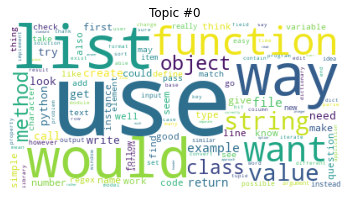

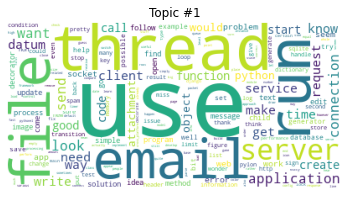

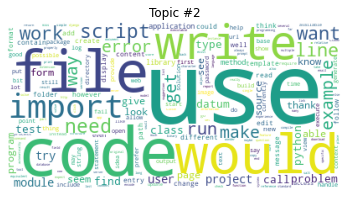

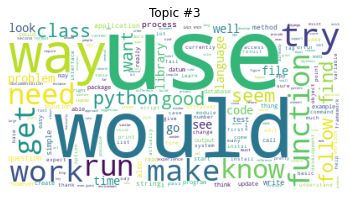

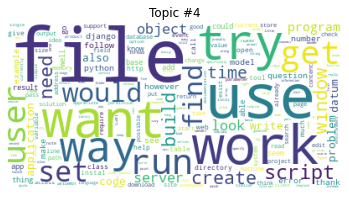

Year 2009


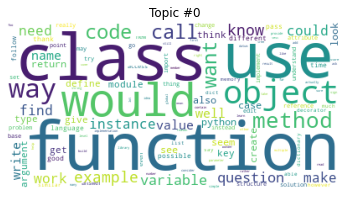

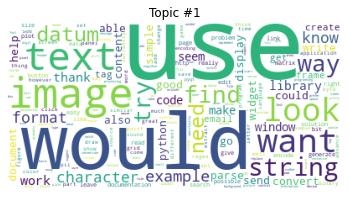

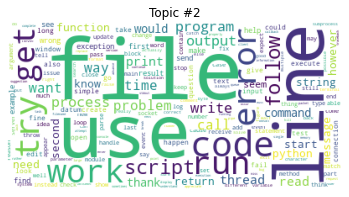

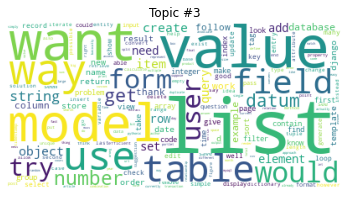

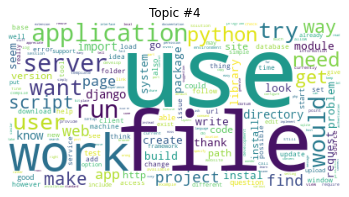

Year 2010


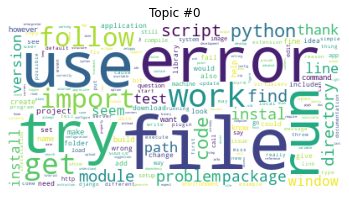

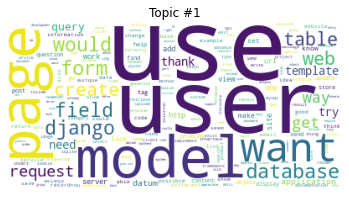

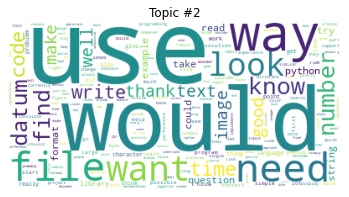

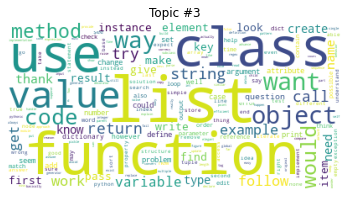

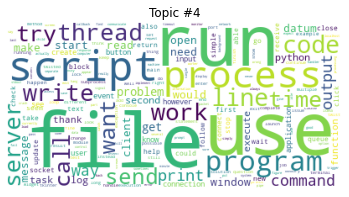

Year 2011


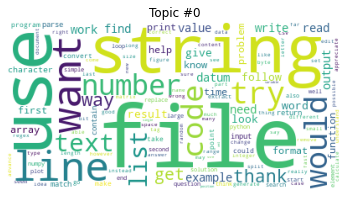

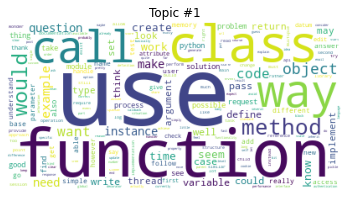

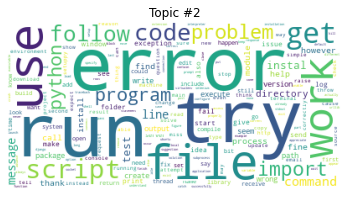

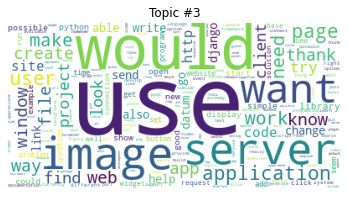

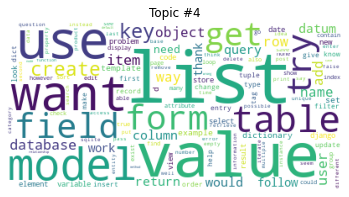

Year 2012


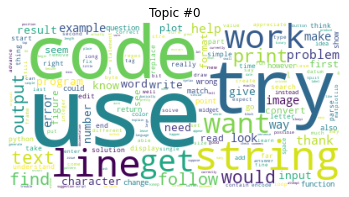

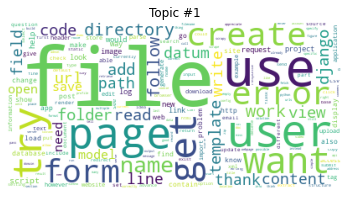

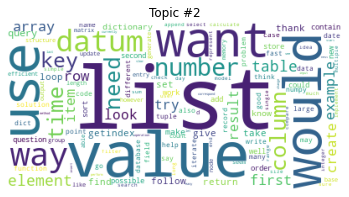

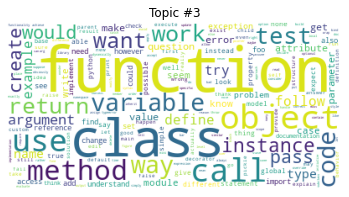

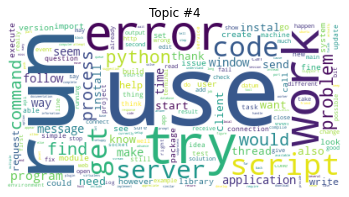

Year 2013


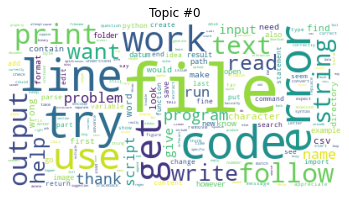

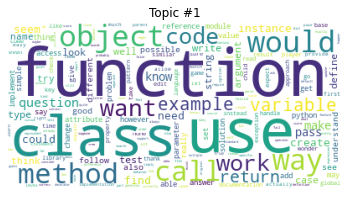

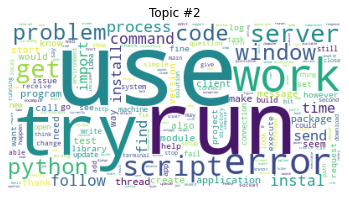

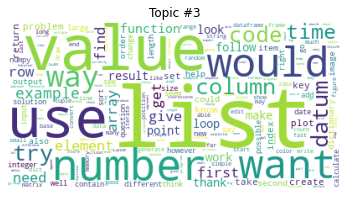

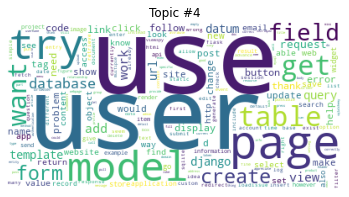

Year 2014


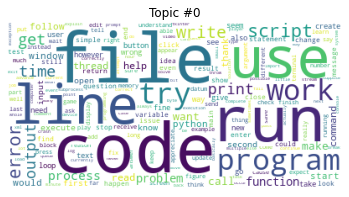

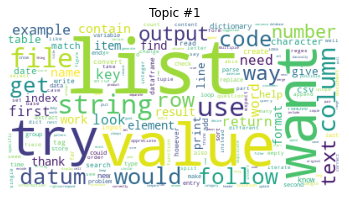

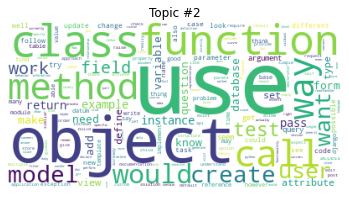

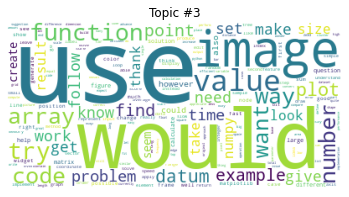

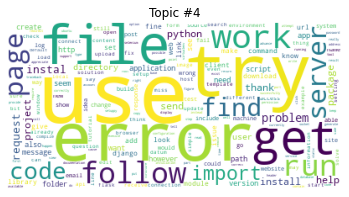

Year 2015


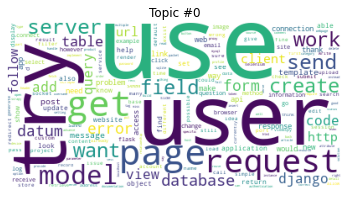

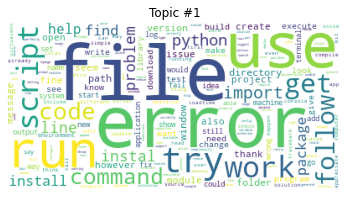

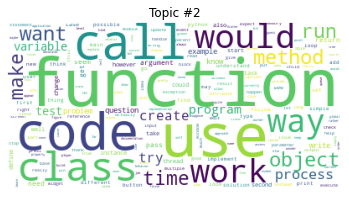

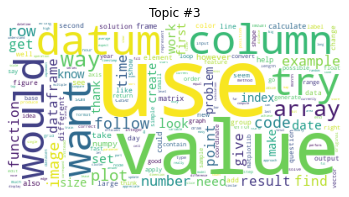

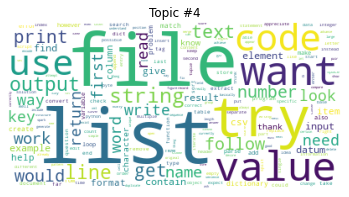

Year 2016


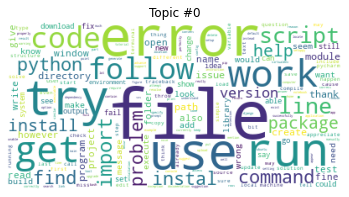

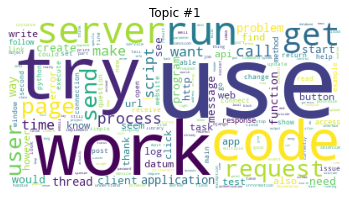

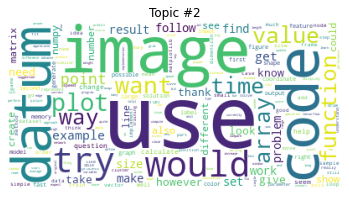

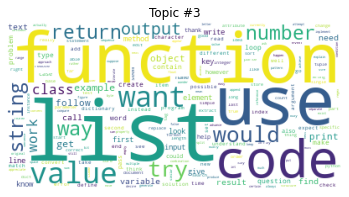

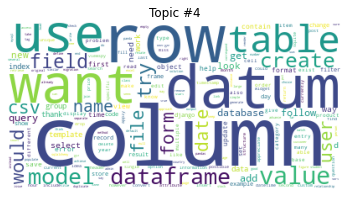

Success!
Wall time: 31.3 s


In [32]:
%%time

# Generate wordcloud per topic for each model
for year in lda_model_year.keys():
    print("Year {}".format(year))
    show_word_cloud_by_topic(lda_model_year[year])

print("Success!")

**\[checkpoint\]** Save LDA models.

In [33]:
%%time

with open('output/lda_model_year.pickle', 'wb') as lda_model:
    pickle.dump(lda_model_year, lda_model)
    
print("Success!")

Success!
Wall time: 1.38 s


Verify that the LDA models are saved successfully.

In [34]:
%%time

with open('output/lda_model_year.pickle', 'rb') as lda_model:
    lda_model_year_test = pickle.load(lda_model)
        
print("Success!")

Success!
Wall time: 190 ms


In [35]:
# Print keywords per topic for each model
for year in lda_model_year_test.keys():
    print("Year {}".format(year))
    pprint(lda_model_year_test[year].print_topics())
    print("---")
    
print("Success!")

Year 2008
[(0,
  '0.020*"use" + 0.019*"list" + 0.018*"way" + 0.017*"would" + 0.013*"function" '
  '+ 0.011*"want" + 0.011*"string" + 0.010*"value" + 0.009*"object" + '
  '0.009*"method"'),
 (1,
  '0.025*"use" + 0.010*"thread" + 0.009*"run" + 0.008*"file" + 0.008*"email" + '
  '0.008*"server" + 0.007*"application" + 0.007*"look" + 0.007*"connection" + '
  '0.007*"want"'),
 (2,
  '0.027*"use" + 0.016*"code" + 0.011*"file" + 0.010*"would" + 0.009*"write" + '
  '0.008*"import" + 0.008*"script" + 0.008*"need" + 0.007*"work" + '
  '0.007*"want"'),
 (3,
  '0.023*"use" + 0.013*"would" + 0.010*"way" + 0.010*"try" + 0.008*"work" + '
  '0.008*"make" + 0.007*"need" + 0.007*"function" + 0.007*"get" + 0.007*"run"'),
 (4,
  '0.024*"file" + 0.016*"use" + 0.012*"work" + 0.011*"want" + 0.010*"try" + '
  '0.010*"way" + 0.009*"run" + 0.008*"get" + 0.008*"user" + 0.007*"set"')]
---
Year 2009
[(0,
  '0.023*"function" + 0.021*"class" + 0.020*"use" + 0.015*"would" + '
  '0.014*"object" + 0.012*"way" + 0.012*"

### Coherence: Evaluating LDA Model

Evaluate LDA model using coherence using [`CoherenceModel`](https://radimrehurek.com/gensim/models/coherencemodel.html) from `Gensim` library.

In [36]:
# Helper function
def compute_coherence_value_by_model(model, data_lemmatized, id2word):
    coherence_model_lda = CoherenceModel(model=model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [37]:
%%time

# Compute coherence score for each model (for each year)
for year in lda_model_year.keys():
    print("Coherence Score (Year {}): {}".format(
        year, compute_coherence_value_by_model(lda_model_year[year], data_lemmatized_year[year], id2word_year[year])
    ))
    
print("Success!")

Coherence Score (Year 2008): 0.3752180787545615
Coherence Score (Year 2009): 0.4117120047291184
Coherence Score (Year 2010): 0.4588714511285989
Coherence Score (Year 2011): 0.445293343596192
Coherence Score (Year 2012): 0.4313777673881517
Coherence Score (Year 2013): 0.46387630431855376
Coherence Score (Year 2014): 0.43045218971465127
Coherence Score (Year 2015): 0.4383649681139786
Coherence Score (Year 2016): 0.4436942743110032
Success!
Wall time: 1min 35s


# Section 4: Experiment 2 - Topic Modelling on Questions with High Scores <a name="sec4"></a>

In Experiment 2, we will also build LDA model to perform topic modelling tasks as demonstrated in Experiment 1 ([**Section 3**](#sec3). However, we will train our model using Python questions with high scores only. We do not split the questions by years. Furthermore, we will examine the effect of choosing the number of topics suggested by hyperparameter tuning on the keywords for each topic of the LDA model generated.

We start this experiment using the dataset after going through general text processing in [**Section 2**](#sec2).

In [44]:
# Load preprocessed dataset
df_nonneg_2 = pd.read_csv('output/Questions_processed.csv')
df_nonneg_2

Unnamed: 0  Score  CreationYear  \
0                0     21          2008   
1                1     27          2008   
2                2     40          2008   
3                3     25          2008   
4                4     28          2008   
...            ...    ...           ...   
570967      570967      1          2016   
570968      570968      0          2016   
570969      570969      0          2016   
570970      570970      2          2016   
570971      570971      0          2016   

                                            BodyProcessed  
0       i am using the photoshop's javascript api to f...  
1       i have a cross-platform (python) application w...  
2       i'm starting work on a hobby project with a py...  
3       there are several ways to iterate over a resul...  
4       i don't remember whether i was dreaming or not...  
...                                                   ...  
570967  i need to extend a shell script (bash) as i am...  
570968  i understood that recaptcha loads a new frame ...  
570969  i'm trying to set up this api so i can use a "...  
570970  given a list of values and information on poss...  
570971  so i'm trying to learn how to use theano and s...  

[570972 rows x 4 columns]

For this experiment, we focus on the questions with the top 10% highest score from 2008 - 2016. 

In [45]:
np.quantile(df_nonneg_2['Score'], 0.90) # 90 Percentile = top 10%

4.0

From the previous output, we learn that only about 10% of the Python questions posted on Stack Overflow have scores greater than 4. We will use these question for this experiment.

In [46]:
df_nonneg_score = df_nonneg_2[df_nonneg_2['Score'] >= 4]
df_nonneg_score

Unnamed: 0  Score  CreationYear  \
0                0     21          2008   
1                1     27          2008   
2                2     40          2008   
3                3     25          2008   
4                4     28          2008   
...            ...    ...           ...   
570744      570744      5          2016   
570776      570776      4          2016   
570778      570778      7          2016   
570881      570881      4          2016   
570921      570921      4          2016   

                                            BodyProcessed  
0       i am using the photoshop's javascript api to f...  
1       i have a cross-platform (python) application w...  
2       i'm starting work on a hobby project with a py...  
3       there are several ways to iterate over a resul...  
4       i don't remember whether i was dreaming or not...  
...                                                   ...  
570744  i have a dataset in a textfile that looks like...  
570776  i was doing some performance evaluation using ...  
570778  now that __init__py is no longer required to m...  
570881  ultimately i want to remove all explicit loops...  
570921  consider the df\ni expected the following two ...  

[74195 rows x 4 columns]

## 4-1: Text Processing Stage 2 <a name="4_1"></a>

Similar to [**Section 3-1**](#3_1), we want to perform word tokenization on the descriptions of the questions with score greater than 4.

### Word Tokenization

We use the helper function `sent_to_words()` defined from **Section 3-1**.

In [47]:
data_words_score = list(sent_to_words(df_nonneg_score['BodyProcessed']))
print(data_words_score[:1][0][:30])
print("Success!")

['am', 'using', 'the', 'photoshop', 'javascript', 'api', 'to', 'find', 'the', 'fonts', 'in', 'given', 'psd', 'given', 'font', 'name', 'returned', 'by', 'the', 'api', 'want', 'to', 'find', 'the', 'actual', 'physical', 'font', 'file', 'that', 'that']
Success!


### Build Bigram

In [48]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words_score, min_count=5, threshold=100) # higher threshold fewer phrases.
# trigram = gensim.models.Phrases(bigram[data_words_score], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)

print("Success!")

Success!


### Remove Stopwords and Lemmatization

In [49]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words_score)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops, bigram_mod)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized_score = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized_score[:1][0][:30])

print("Success!")

['use', 'find', 'font', 'give', 'give', 'font', 'name', 'return', 'want', 'find', 'actual', 'physical', 'font', 'file', 'font', 'name', 'correspond', 'disc', 'happen', 'program', 'run', 'guess', 'look', 'function', 'call']
Success!


**\[Checkpoint\]** Save the lemmatized tokens.

In [50]:
%%time

with open('output/data_lemmatized_score.pickle', 'wb') as data_lemmatized:
    pickle.dump(data_lemmatized_score, data_lemmatized)
    
print("Success!")

Success!
Wall time: 1.22 s


Verify that the lemmatized tokens are saved successfully.

In [51]:
%%time

with open('output/data_lemmatized_score.pickle', 'rb') as data_lemmatized:
    data_lemmatized_score = pickle.load(data_lemmatized)
print("Success!")

print(data_lemmatized_score[:1][0][:30])
print("Success!")

Success!
['use', 'find', 'font', 'give', 'give', 'font', 'name', 'return', 'want', 'find', 'actual', 'physical', 'font', 'file', 'font', 'name', 'correspond', 'disc', 'happen', 'program', 'run', 'guess', 'look', 'function', 'call']
Success!
Wall time: 684 ms


## 4-2: LDA Model <a name="4_2"></a>

### Build LDA Model

In [52]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized_score)

# Create Corpus
texts = data_lemmatized_score

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 4), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]


We build LDA model with 5 topics as our baseline model.

In [53]:
lda_model_score = create_lda_model(corpus, id2word, num_topics=5)

### Inspect Keywords by Topics

In [54]:
# Print the Keyword in each topic
pprint(lda_model_score.print_topics())

[(0,
  '0.033*"function" + 0.022*"use" + 0.020*"class" + 0.020*"object" + '
  '0.017*"call" + 0.015*"method" + 0.013*"code" + 0.012*"way" + 0.011*"return" '
  '+ 0.011*"work"'),
 (1,
  '0.022*"list" + 0.019*"use" + 0.017*"value" + 0.014*"would" + 0.013*"way" + '
  '0.012*"want" + 0.011*"number" + 0.010*"column" + 0.009*"time" + '
  '0.008*"example"'),
 (2,
  '0.060*"file" + 0.028*"line" + 0.027*"use" + 0.024*"string" + 0.022*"try" + '
  '0.016*"code" + 0.013*"plot" + 0.013*"output" + 0.013*"want" + '
  '0.012*"follow"'),
 (3,
  '0.030*"use" + 0.025*"run" + 0.017*"try" + 0.016*"error" + 0.015*"work" + '
  '0.011*"get" + 0.010*"script" + 0.010*"code" + 0.009*"file" + '
  '0.008*"follow"'),
 (4,
  '0.029*"use" + 0.017*"user" + 0.017*"image" + 0.013*"model" + 0.011*"try" + '
  '0.011*"get" + 0.011*"page" + 0.010*"want" + 0.010*"create" + '
  '0.009*"request"')]


## 4-3: Visualization and Evaluation <a name="4_3"></a>

Generate word cloud for each topic.

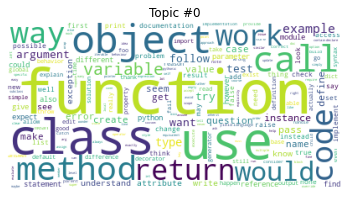

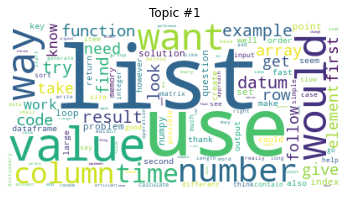

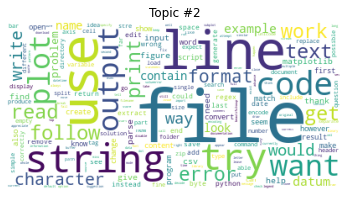

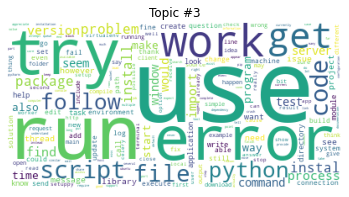

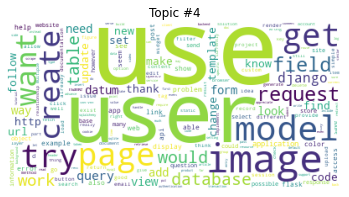

In [55]:
show_word_cloud_by_topic(lda_model_score)

**\[Checkpoint\]** Save LDA model.

In [56]:
%%time

with open('output/lda_model_score.pickle', 'wb') as lda_model:
    pickle.dump(lda_model_score, lda_model)
    
print("Success!")

Success!
Wall time: 27 ms


Verify that the model has successfully saved.

In [57]:
%%time

with open('output/lda_model_score.pickle', 'rb') as lda_model:
    lda_model_score = pickle.load(lda_model)
        
print("Success!")

Success!
Wall time: 46 ms


In [58]:
# Print the Keyword in each topic
pprint(lda_model_score.print_topics())
    
print("Success!")

[(0,
  '0.033*"function" + 0.022*"use" + 0.020*"class" + 0.020*"object" + '
  '0.017*"call" + 0.015*"method" + 0.013*"code" + 0.012*"way" + 0.011*"return" '
  '+ 0.011*"work"'),
 (1,
  '0.022*"list" + 0.019*"use" + 0.017*"value" + 0.014*"would" + 0.013*"way" + '
  '0.012*"want" + 0.011*"number" + 0.010*"column" + 0.009*"time" + '
  '0.008*"example"'),
 (2,
  '0.060*"file" + 0.028*"line" + 0.027*"use" + 0.024*"string" + 0.022*"try" + '
  '0.016*"code" + 0.013*"plot" + 0.013*"output" + 0.013*"want" + '
  '0.012*"follow"'),
 (3,
  '0.030*"use" + 0.025*"run" + 0.017*"try" + 0.016*"error" + 0.015*"work" + '
  '0.011*"get" + 0.010*"script" + 0.010*"code" + 0.009*"file" + '
  '0.008*"follow"'),
 (4,
  '0.029*"use" + 0.017*"user" + 0.017*"image" + 0.013*"model" + 0.011*"try" + '
  '0.011*"get" + 0.011*"page" + 0.010*"want" + 0.010*"create" + '
  '0.009*"request"')]
Success!


## 4-4: Hyperparameter Tuning <a name="4_4"></a>

Hyperparameter tuning is a process that helps us identify the hyperparameter which yields the best model performance through selected evaluation measures. In this case, we specify different number of topics and select the number that generates the topics with the highest coherence score. We define a helper function to compute the coherence score of the LDA model.

In [59]:
# Define helper function
def compute_coherence_values(corpus, dictionary, data_lemmatized, k):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10)
    
    return compute_coherence_value_by_model(lda_model, data_lemmatized, id2word)

We then perform hyperparameter tuning by using the helper function `compute_coherence_values()` as defined earlier.

In [60]:
%%time

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [corpus]

corpus_title = ['100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(topics_range)*len(corpus_title)), position=0)
    
    # iterate through validation corpus
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # get the coherence score for the given parameters
            cv = compute_coherence_values(corpus=corpus_sets[i],
                                          dictionary=id2word,
                                          data_lemmatized=data_lemmatized_score,
                                          k=k)
            # Save the model results
            model_results['Validation_Set'].append(corpus_title[i])
            model_results['Topics'].append(k)
            model_results['Coherence'].append(cv)

            pbar.update(1)
            
    pd.DataFrame(model_results).to_csv('lda_tuning_score.csv', index=False)
    pbar.close()
    
print("Success!")

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [46:14<00:00, 308.31s/it]

Success!
Wall time: 46min 14s


Now, we repeat the process: create LDA model, show the keywords for each topic and then generate word cloud for the respective topics. Here, we select with 8 topics, which is the number of topics yielding the highest coherence score (from "lda_tuning_score.csv") during the hyperparameter tuning process.

In [61]:
lda_model_score = create_lda_model(corpus, id2word, num_topics=8)

In [62]:
# Print the Keyword in each topic
pprint(lda_model_score.print_topics())

[(0,
  '0.040*"function" + 0.025*"class" + 0.023*"use" + 0.023*"object" + '
  '0.020*"call" + 0.018*"method" + 0.013*"return" + 0.012*"code" + 0.012*"way" '
  '+ 0.011*"variable"'),
 (1,
  '0.027*"list" + 0.018*"use" + 0.018*"value" + 0.016*"would" + 0.015*"way" + '
  '0.012*"number" + 0.012*"want" + 0.009*"example" + 0.009*"function" + '
  '0.009*"array"'),
 (2,
  '0.073*"file" + 0.039*"string" + 0.026*"use" + 0.024*"line" + 0.018*"text" + '
  '0.017*"read" + 0.015*"want" + 0.013*"try" + 0.013*"format" + '
  '0.012*"character"'),
 (3,
  '0.031*"use" + 0.013*"server" + 0.013*"request" + 0.012*"process" + '
  '0.011*"run" + 0.011*"time" + 0.010*"test" + 0.010*"would" + 0.009*"thread" '
  '+ 0.008*"application"'),
 (4,
  '0.033*"file" + 0.031*"use" + 0.021*"import" + 0.019*"package" + '
  '0.017*"instal" + 0.017*"install" + 0.016*"try" + 0.013*"version" + '
  '0.013*"find" + 0.013*"work"'),
 (5,
  '0.034*"column" + 0.021*"use" + 0.019*"model" + 0.019*"user" + 0.018*"want" '
  '+ 0.016*"r

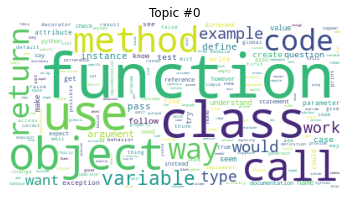

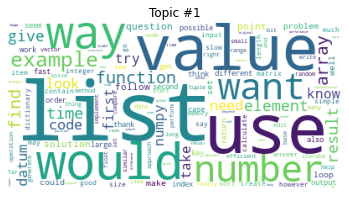

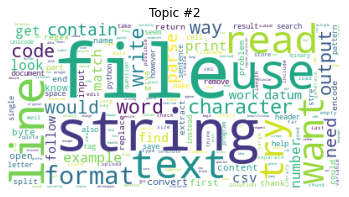

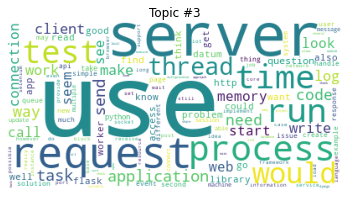

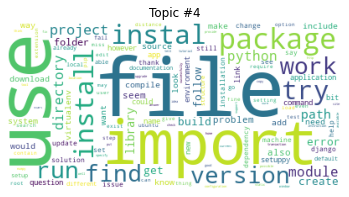

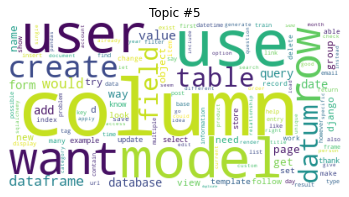

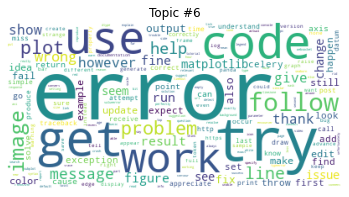

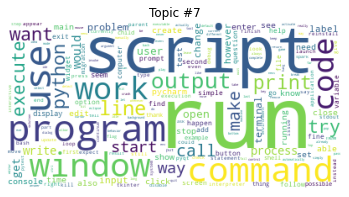

In [63]:
show_word_cloud_by_topic(lda_model_score)

One good thing about the `Gensim` library is that, there is an existing visualization tool from the [`pyLDAvis`](https://pyldavis.readthedocs.io/en/latest/readme.html) library which is used to visualize the results of an LDA model created using the `Gensim` library.

*Note: The topic number on the visualization below might not correspond to the topic number from the word cloud above*.

In [64]:
p = pyLDAvis.gensim.prepare(lda_model_score, corpus, id2word)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.126880 -0.019104       1        1  22.126488
3     -0.031688  0.169960       2        1  15.366918
0     -0.067708  0.011576       3        1  15.129948
4      0.072815  0.086102       4        1  11.357596
6      0.203151 -0.135542       5        1   9.381660
2     -0.018941 -0.107672       6        1   9.360466
5     -0.149372 -0.088075       7        1   9.183286
7      0.118622  0.082754       8        1   8.093643, topic_info=         Term          Freq         Total Category  logprob  loglift
4        file  31925.000000  31925.000000  Default  30.0000  30.0000
379     error  19201.000000  19201.000000  Default  29.0000  29.0000
7    function  24127.000000  24127.000000  Default  28.0000  28.0000
16        run  22953.000000  22953.000000  Default  27.0000  27.0000
287    string  10831.000000  10831.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
66      would   1588.896973  28310.033203   Topic8  -5.0118  -0.3661
241       get   1455.352051  25130.734375   Topic8  -5.0995  -0.3348
104   problem   1352.440308  15841.696289   Topic8  -5.1729   0.0534
517   however   1283.024780  11752.687500   Topic8  -5.2256   0.2992
87     change   1223.604858   8250.218750   Topic8  -5.2730   0.6057

[588 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
5407      8  0.996361  activate
155       1  0.113600       add
155       2  0.031851       add
155       3  0.159677       add
155       4  0.187600       add
...     ...       ...       ...
502       6  0.050483     wrong
502       7  0.022548     wrong
502       8  0.040706     wrong
503       6  0.998165       xml
4199      4  0.997799      zero

[1310 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 5, 7, 3, 6, 8])

Save the visualization for the LDA model as a webpate (i.e., a HTML file) for future reference.

In [65]:
pyLDAvis.save_html(p, 'lda_score_v2.html')